In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
forecasting = 20

In [4]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [5]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

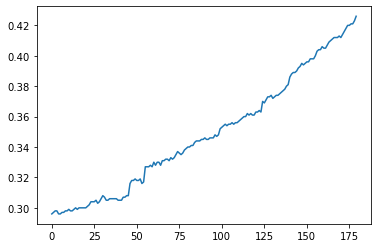

In [6]:
df = df[:180]
df.plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

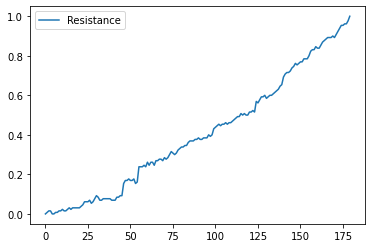

In [8]:
train = df_scaled
train.plot()

In [9]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [11]:
x_train.shape

(128, 20, 1)

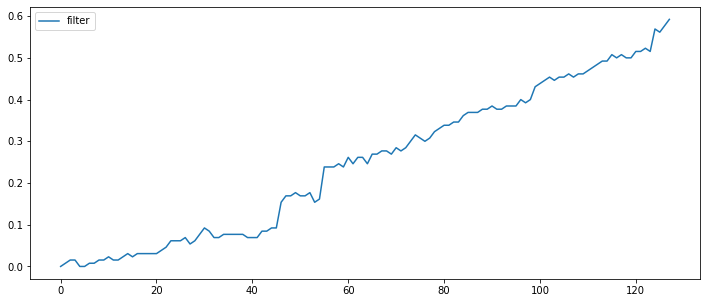

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

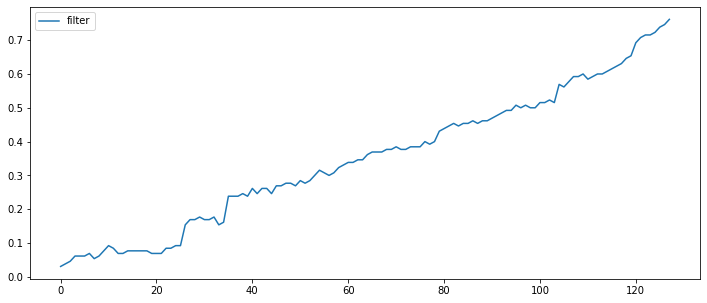

In [13]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [14]:
OUT_STEPS = 20

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
8/8 [==============================] - 1s 3ms/step - loss: 0.1051 - mean_absolute_error: 0.2610
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.1005 - mean_absolute_error: 0.2570
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0844 - mean_absolute_error: 0.2312
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0762 - mean_absolute_error: 0.2186
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0628 - mean_absolute_error: 0.2006
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0576 - mean_absolute_error: 0.1904
Epoch 7/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0338 - mean_absolute_error: 0.1472
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0306 - mean_absolute_error: 0.1423
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0218 - mean_absolute_error: 0.1215
Epoch 10/1000
8/8 [

8/8 [==============================] - 0s 3ms/step - loss: 2.7876e-04 - mean_absolute_error: 0.0129
Epoch 74/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4583e-04 - mean_absolute_error: 0.0122
Epoch 75/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4465e-04 - mean_absolute_error: 0.0121
Epoch 76/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3844e-04 - mean_absolute_error: 0.0119
Epoch 77/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3047e-04 - mean_absolute_error: 0.0118
Epoch 78/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1338e-04 - mean_absolute_error: 0.0114
Epoch 79/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3111e-04 - mean_absolute_error: 0.0117
Epoch 80/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4051e-04 - mean_absolute_error: 0.0121
Epoch 81/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3945e-04 - mean_absolute_er

8/8 [==============================] - 0s 3ms/step - loss: 1.9417e-04 - mean_absolute_error: 0.0109
Epoch 145/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0939e-04 - mean_absolute_error: 0.0114
Epoch 146/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1190e-04 - mean_absolute_error: 0.0114
Epoch 147/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0462e-04 - mean_absolute_error: 0.0114
Epoch 148/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2663e-04 - mean_absolute_error: 0.0119
Epoch 149/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1100e-04 - mean_absolute_error: 0.0114
Epoch 150/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0401e-04 - mean_absolute_error: 0.0112
Epoch 151/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.0831e-04 - mean_absolute_error: 0.0113
Epoch 152/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1388e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.8738e-04 - mean_absolute_error: 0.0107
Epoch 216/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9030e-04 - mean_absolute_error: 0.0108
Epoch 217/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9047e-04 - mean_absolute_error: 0.0109
Epoch 218/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9001e-04 - mean_absolute_error: 0.0108
Epoch 219/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8350e-04 - mean_absolute_error: 0.0106
Epoch 220/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8359e-04 - mean_absolute_error: 0.0106
Epoch 221/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9494e-04 - mean_absolute_error: 0.0109
Epoch 222/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8283e-04 - mean_absolute_error: 0.0105
Epoch 223/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0406e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.7482e-04 - mean_absolute_error: 0.0104
Epoch 286/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7850e-04 - mean_absolute_error: 0.0105
Epoch 287/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8137e-04 - mean_absolute_error: 0.0105
Epoch 288/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9109e-04 - mean_absolute_error: 0.0108
Epoch 289/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8538e-04 - mean_absolute_error: 0.0106
Epoch 290/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8779e-04 - mean_absolute_error: 0.0106
Epoch 291/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7305e-04 - mean_absolute_error: 0.0103
Epoch 292/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6685e-04 - mean_absolute_error: 0.0101
Epoch 293/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7222e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.8039e-04 - mean_absolute_error: 0.0105
Epoch 356/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7495e-04 - mean_absolute_error: 0.0103
Epoch 357/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8029e-04 - mean_absolute_error: 0.0104
Epoch 358/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7478e-04 - mean_absolute_error: 0.0102
Epoch 359/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6390e-04 - mean_absolute_error: 0.0100
Epoch 360/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5211e-04 - mean_absolute_error: 0.0096
Epoch 361/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5614e-04 - mean_absolute_error: 0.0097
Epoch 362/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6201e-04 - mean_absolute_error: 0.0099
Epoch 363/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8951e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5726e-04 - mean_absolute_error: 0.0097
Epoch 427/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6379e-04 - mean_absolute_error: 0.0100
Epoch 428/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6727e-04 - mean_absolute_error: 0.0100
Epoch 429/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7194e-04 - mean_absolute_error: 0.0103
Epoch 430/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6450e-04 - mean_absolute_error: 0.0099
Epoch 431/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7232e-04 - mean_absolute_error: 0.0101
Epoch 432/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5034e-04 - mean_absolute_error: 0.0096
Epoch 433/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6788e-04 - mean_absolute_error: 0.0101
Epoch 434/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7297e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5226e-04 - mean_absolute_error: 0.0096
Epoch 498/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6771e-04 - mean_absolute_error: 0.0100
Epoch 499/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6866e-04 - mean_absolute_error: 0.0102
Epoch 500/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6204e-04 - mean_absolute_error: 0.0098
Epoch 501/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7315e-04 - mean_absolute_error: 0.0103
Epoch 502/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6188e-04 - mean_absolute_error: 0.0098
Epoch 503/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5114e-04 - mean_absolute_error: 0.0095
Epoch 504/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6811e-04 - mean_absolute_error: 0.0100
Epoch 505/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5887e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4572e-04 - mean_absolute_error: 0.0095
Epoch 569/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7180e-04 - mean_absolute_error: 0.0101
Epoch 570/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5883e-04 - mean_absolute_error: 0.0098
Epoch 571/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3684e-04 - mean_absolute_error: 0.0091
Epoch 572/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5886e-04 - mean_absolute_error: 0.0098
Epoch 573/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5702e-04 - mean_absolute_error: 0.0098
Epoch 574/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6466e-04 - mean_absolute_error: 0.0100
Epoch 575/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5609e-04 - mean_absolute_error: 0.0097
Epoch 576/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7496e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.6279e-04 - mean_absolute_error: 0.0098
Epoch 640/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5569e-04 - mean_absolute_error: 0.0096
Epoch 641/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6077e-04 - mean_absolute_error: 0.0098
Epoch 642/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5730e-04 - mean_absolute_error: 0.0097
Epoch 643/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7257e-04 - mean_absolute_error: 0.0103
Epoch 644/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5236e-04 - mean_absolute_error: 0.0094
Epoch 645/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6021e-04 - mean_absolute_error: 0.0099
Epoch 646/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5789e-04 - mean_absolute_error: 0.0097
Epoch 647/1000
8/8 [==============================] - ETA: 0s - loss: 1.7298e-04 - mean_absolut

8/8 [==============================] - 0s 3ms/step - loss: 1.6041e-04 - mean_absolute_error: 0.0099
Epoch 710/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6485e-04 - mean_absolute_error: 0.0100
Epoch 711/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4230e-04 - mean_absolute_error: 0.0092
Epoch 712/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6122e-04 - mean_absolute_error: 0.0099
Epoch 713/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5038e-04 - mean_absolute_error: 0.0094
Epoch 714/1000
8/8 [==============================] - ETA: 0s - loss: 1.0160e-04 - mean_absolute_error: 0.008 - 0s 3ms/step - loss: 1.4362e-04 - mean_absolute_error: 0.0093
Epoch 715/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6386e-04 - mean_absolute_error: 0.0099
Epoch 716/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6884e-04 - mean_absolute_error: 0.0100
Epoch 717/1000
8/8 [=================

8/8 [==============================] - 0s 3ms/step - loss: 1.4507e-04 - mean_absolute_error: 0.0093
Epoch 779/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5438e-04 - mean_absolute_error: 0.0096
Epoch 780/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6176e-04 - mean_absolute_error: 0.0097
Epoch 781/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4415e-04 - mean_absolute_error: 0.0093
Epoch 782/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5571e-04 - mean_absolute_error: 0.0096
Epoch 783/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5285e-04 - mean_absolute_error: 0.0096
Epoch 784/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5984e-04 - mean_absolute_error: 0.0097
Epoch 785/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5260e-04 - mean_absolute_error: 0.0097
Epoch 786/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4859e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5599e-04 - mean_absolute_error: 0.0096
Epoch 849/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3753e-04 - mean_absolute_error: 0.0090
Epoch 850/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5975e-04 - mean_absolute_error: 0.0097
Epoch 851/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.4424e-04 - mean_absolute_error: 0.0092
Epoch 852/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5678e-04 - mean_absolute_error: 0.0097
Epoch 853/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6164e-04 - mean_absolute_error: 0.0097
Epoch 854/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5502e-04 - mean_absolute_error: 0.0095
Epoch 855/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5149e-04 - mean_absolute_error: 0.0094
Epoch 856/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5107e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5154e-04 - mean_absolute_error: 0.0095
Epoch 920/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6154e-04 - mean_absolute_error: 0.0098
Epoch 921/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6083e-04 - mean_absolute_error: 0.0097
Epoch 922/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6027e-04 - mean_absolute_error: 0.0097
Epoch 923/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5585e-04 - mean_absolute_error: 0.0096
Epoch 924/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3998e-04 - mean_absolute_error: 0.0091
Epoch 925/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5565e-04 - mean_absolute_error: 0.0095
Epoch 926/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4092e-04 - mean_absolute_error: 0.0092
Epoch 927/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5244e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4567e-04 - mean_absolute_error: 0.0093
Epoch 991/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7204e-04 - mean_absolute_error: 0.0100
Epoch 992/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4205e-04 - mean_absolute_error: 0.0092
Epoch 993/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5590e-04 - mean_absolute_error: 0.0096
Epoch 994/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5116e-04 - mean_absolute_error: 0.0095
Epoch 995/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4534e-04 - mean_absolute_error: 0.0093
Epoch 996/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5063e-04 - mean_absolute_error: 0.0094
Epoch 997/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6244e-04 - mean_absolute_error: 0.0098
Epoch 998/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5019e-04 - mean_abs

num 0 10.578455408414177 actual 0.7389162561576352 prediction 0.6607503
num 1 7.200934345784937 actual 0.7487684729064039 prediction 0.69485015
num 2 6.052447884690483 actual 0.7536945812807878 prediction 0.7080776
num 3 6.75662349570878 actual 0.7586206896551722 prediction 0.70736355
num 4 5.277798802424694 actual 0.7684729064039408 prediction 0.72791445
num 5 4.940065494768186 actual 0.7733990147783252 prediction 0.7351926
num 6 5.207933881614747 actual 0.7783251231527091 prediction 0.73779047
num 7 7.866264251792934 actual 0.7832512315270934 prediction 0.7216386
num 8 4.909686036407939 actual 0.7881773399014778 prediction 0.7494803
num 9 7.032437169033552 actual 0.7931034482758621 prediction 0.73732895
num 10 5.404254904499724 actual 0.798029556650246 prediction 0.754902
num 11 2.334154277671965 actual 0.798029556650246 prediction 0.7794023
num 12 1.4296068650920095 actual 0.8078817733990147 prediction 0.79633224
num 13 2.3633780593643374 actual 0.8226600985221673 prediction 0.80321

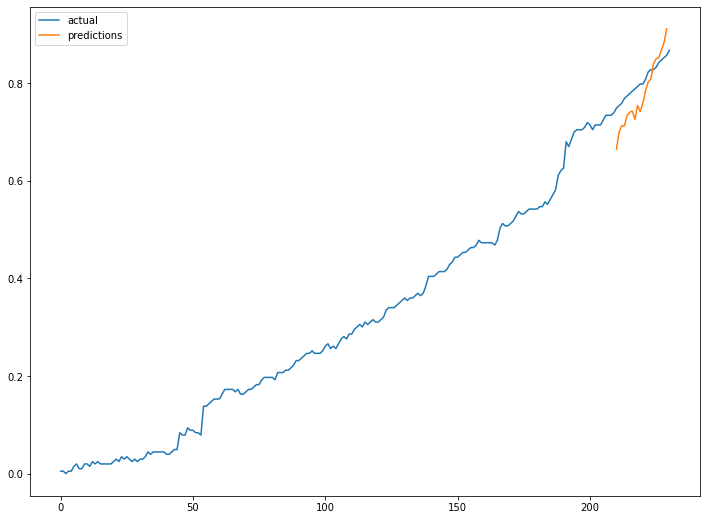

In [17]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 13.88328469529442 actual 0.8006535947712417 prediction 0.6894966
num 1 9.539852507652775 actual 0.8104575163398693 prediction 0.73314106
num 2 7.915708243128765 actual 0.8137254901960784 prediction 0.74931335
num 3 8.835987377166745 actual 0.8169934640522876 prediction 0.744804
num 4 5.789494466781615 actual 0.8169934640522876 prediction 0.7696937
num 5 5.221870458458521 actual 0.8202614379084967 prediction 0.77742845
num 6 5.597421020387184 actual 0.826797385620915 prediction 0.78051805
num 7 9.723912179470053 actual 0.8366013071895424 prediction 0.75525093
num 8 6.639604770999144 actual 0.8464052287581698 prediction 0.79020727
num 9 9.373126358821459 actual 0.8529411764705881 prediction 0.7729939
num 10 7.709227632660358 actual 0.8594771241830064 prediction 0.7932181
num 11 4.517645727504363 actual 0.8627450980392155 prediction 0.82376933
num 12 2.5116396400163543 actual 0.8660130718954246 prediction 0.84426194
num 13 1.947537683091052 actual 0.8660130718954246 prediction 0.849

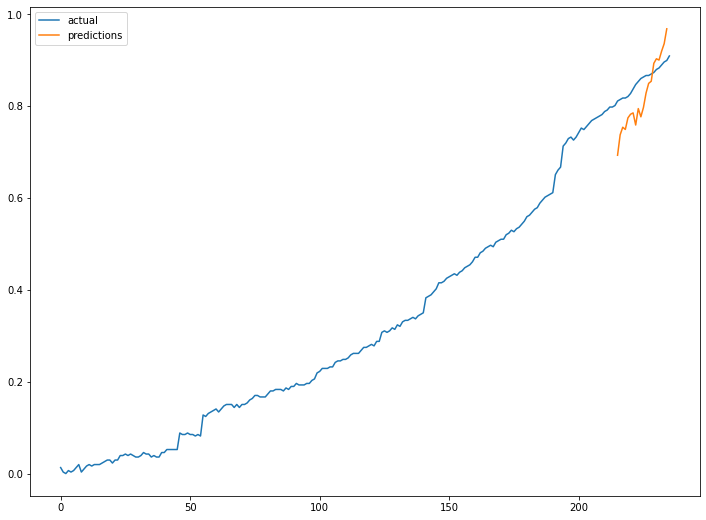

In [18]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.60429519873406 actual 0.6190476190476186 prediction 0.63516945
num 1 2.8480917215346424 actual 0.6666666666666661 prediction 0.6476794
num 2 6.746238470077415 actual 0.7142857142857135 prediction 0.6660983
num 3 12.040053308010199 actual 0.7619047619047628 prediction 0.670171
num 4 4.832442998886007 actual 0.7142857142857135 prediction 0.67976826
num 5 3.8426786661148995 actual 0.6666666666666661 prediction 0.6922845
num 6 3.6335825920105904 actual 0.6666666666666661 prediction 0.69089055
num 7 1.5937626361847825 actual 0.6666666666666661 prediction 0.67729175
num 8 2.339086532592669 actual 0.7142857142857135 prediction 0.69757795
num 9 3.9791607856749462 actual 0.7142857142857135 prediction 0.68586314
num 10 1.7029070854185966 actual 0.7142857142857135 prediction 0.7021221
num 11 7.938510179519749 actual 0.6666666666666661 prediction 0.71959007
num 12 3.177469968795886 actual 0.7142857142857135 prediction 0.7369819
num 13 1.8608499318362373 actual 0.7619047619047628 prediction

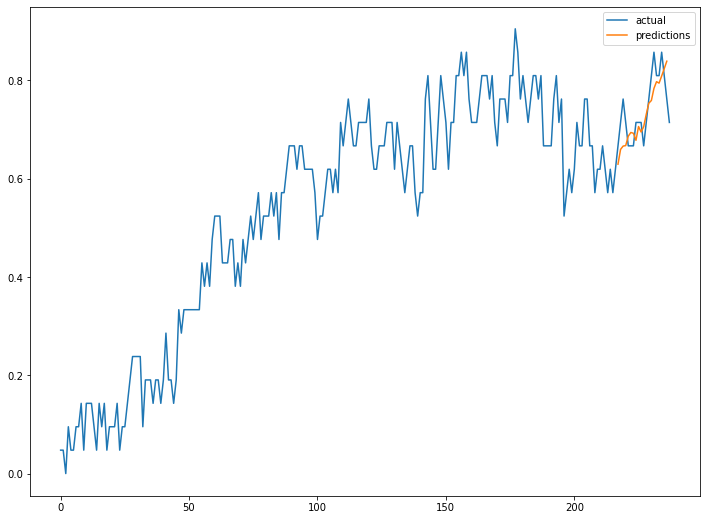

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

214
(235, 20, 1)
num 0 5.181682432020024 actual 0.6762402088772845 prediction 0.6411996
num 1 3.8205767897042207 actual 0.6892950391644908 prediction 0.66296
num 2 2.690352170208395 actual 0.6971279373368144 prediction 0.67837274
num 3 3.1023060078957494 actual 0.702349869451697 prediction 0.6805608
num 4 1.7453834359496105 actual 0.7075718015665795 prediction 0.69522196
num 5 1.5716741337393352 actual 0.7154046997389034 prediction 0.70416087
num 6 3.0278541067595093 actual 0.7284595300261096 prediction 0.70640284
num 7 5.992839551224729 actual 0.7389033942558747 prediction 0.6946221
num 8 4.451412336336177 actual 0.7493472584856395 prediction 0.7159907
num 9 6.411041437960812 actual 0.7545691906005221 prediction 0.70619345
num 10 5.428957572976062 actual 0.7650130548302871 prediction 0.7234808
num 11 3.308443491961688 actual 0.7676240208877285 prediction 0.7422276
num 12 1.482949187966439 actual 0.7676240208877285 prediction 0.75624055
num 13 1.5838894868056907 actual 0.77806788511749

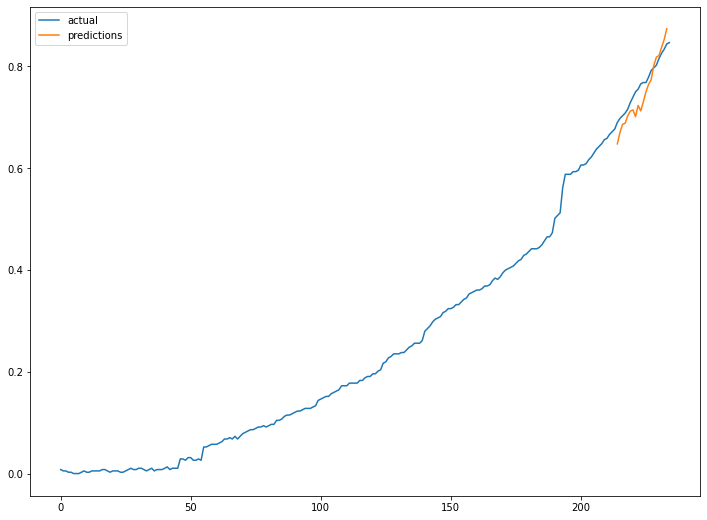

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

print(plot_len)
print(train_feature2.shape)

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 11.426215422780823 actual 0.7916666666666661 prediction 0.7012091
num 1 3.6672190616004623 actual 0.7916666666666661 prediction 0.7626345
num 2 2.294206619262622 actual 0.7916666666666661 prediction 0.7735042
num 3 1.6107797622680664 actual 0.75 prediction 0.76208085
num 4 0.8630300823011651 actual 0.7916666666666661 prediction 0.798499
num 5 7.235519091288249 actual 0.75 prediction 0.8042664
num 6 3.1980967521668164 actual 0.8333333333333339 prediction 0.8066825
num 7 7.910759449005192 actual 0.8333333333333339 prediction 0.76741034
num 8 10.976741530678432 actual 0.9166666666666661 prediction 0.81604654
num 9 17.31490052264675 actual 0.9583333333333339 prediction 0.79239887
num 10 15.636848366778883 actual 0.9583333333333339 prediction 0.8084802
num 11 11.027504050213413 actual 0.9583333333333339 prediction 0.8526531
num 12 7.618713378906307 actual 0.9583333333333339 prediction 0.88532066
num 13 7.734136996061963 actual 0.9583333333333339 prediction 0.8842145
num 14 1.358766989

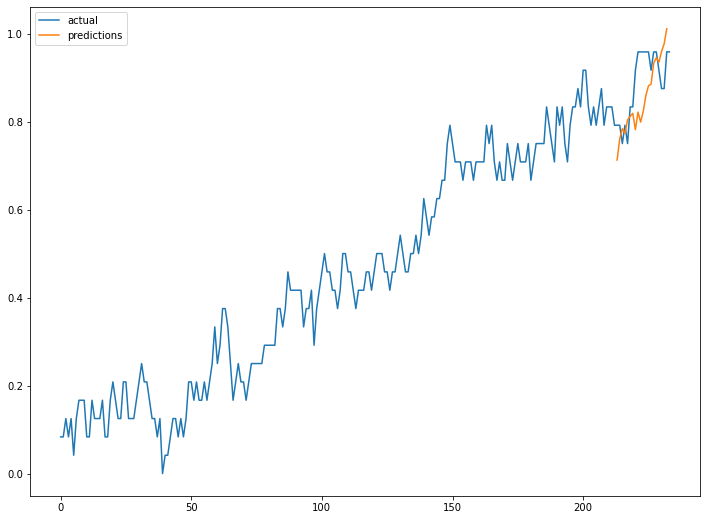

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 16.600916009200233 actual 0.8482142857142856 prediction 0.70740294
num 1 11.222816507021546 actual 0.8571428571428568 prediction 0.7609473
num 2 8.321666717529283 actual 0.8482142857142856 prediction 0.7776287
num 3 9.732609893639022 actual 0.8526785714285712 prediction 0.7696907
num 4 7.735634833267034 actual 0.8660714285714284 prediction 0.7990753
num 5 7.819754736764091 actual 0.875 prediction 0.80657715
num 6 7.902428099346631 actual 0.8794642857142856 prediction 0.80996525
num 7 12.526494893596363 actual 0.8883928571428568 prediction 0.7771084
num 8 7.357261156794974 actual 0.8839285714285712 prediction 0.81889564
num 9 10.18899313768546 actual 0.8883928571428568 prediction 0.79787457
num 10 7.342264387342638 actual 0.8839285714285712 prediction 0.8190282
num 11 4.18380165100097 actual 0.8928571428571428 prediction 0.8555018
num 12 2.444501442484302 actual 0.901785714285714 prediction 0.87974155
num 13 2.6501688463934534 actual 0.90625 prediction 0.88223284
num 14 2.20417811

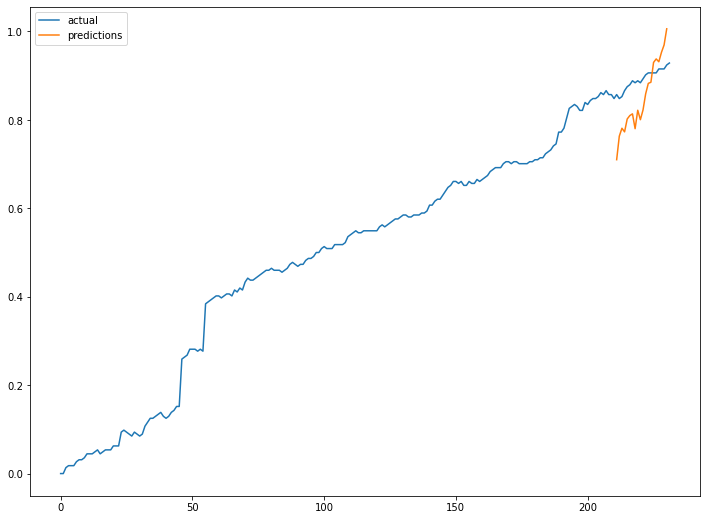

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 29.58974137025733 actual 0.8500000000000014 prediction 0.5984872
num 1 18.413154780864787 actual 0.8000000000000007 prediction 0.65269476
num 2 14.654072125752768 actual 0.75 prediction 0.64009446
num 3 14.545416831970215 actual 0.75 prediction 0.6409094
num 4 10.616668065388996 actual 0.75 prediction 0.670375
num 5 11.105680465698242 actual 0.75 prediction 0.6667074
num 6 4.221534729004052 actual 0.7000000000000011 prediction 0.67044926
num 7 4.223033360072691 actual 0.7000000000000011 prediction 0.67043877
num 8 7.564806938171328 actual 0.6500000000000004 prediction 0.69917125
num 9 0.15113353729263249 actual 0.7000000000000011 prediction 0.69894207
num 10 6.061323483784994 actual 0.75 prediction 0.7045401
num 11 2.602982521057129 actual 0.75 prediction 0.73047763
num 12 6.662171227591215 actual 0.7000000000000011 prediction 0.7466352
num 13 6.745745454515567 actual 0.7000000000000011 prediction 0.7472202
num 14 4.829323291778649 actual 0.8000000000000007 prediction 0.7613654
n

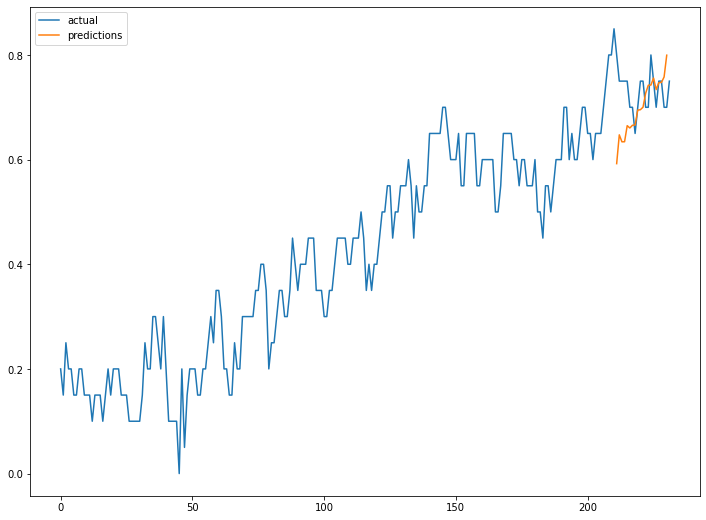

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 29.58974137025733 actual 0.8500000000000014 prediction 0.5984872
num 1 18.413154780864787 actual 0.8000000000000007 prediction 0.65269476
num 2 14.654072125752768 actual 0.75 prediction 0.64009446
num 3 14.545416831970215 actual 0.75 prediction 0.6409094
num 4 10.616668065388996 actual 0.75 prediction 0.670375
num 5 11.105680465698242 actual 0.75 prediction 0.6667074
num 6 4.221534729004052 actual 0.7000000000000011 prediction 0.67044926
num 7 4.223033360072691 actual 0.7000000000000011 prediction 0.67043877
num 8 7.564806938171328 actual 0.6500000000000004 prediction 0.69917125
num 9 0.15113353729263249 actual 0.7000000000000011 prediction 0.69894207
num 10 6.061323483784994 actual 0.75 prediction 0.7045401
num 11 2.602982521057129 actual 0.75 prediction 0.73047763
num 12 6.662171227591215 actual 0.7000000000000011 prediction 0.7466352
num 13 6.745745454515567 actual 0.7000000000000011 prediction 0.7472202
num 14 4.829323291778649 actual 0.8000000000000007 prediction 0.7613654
n

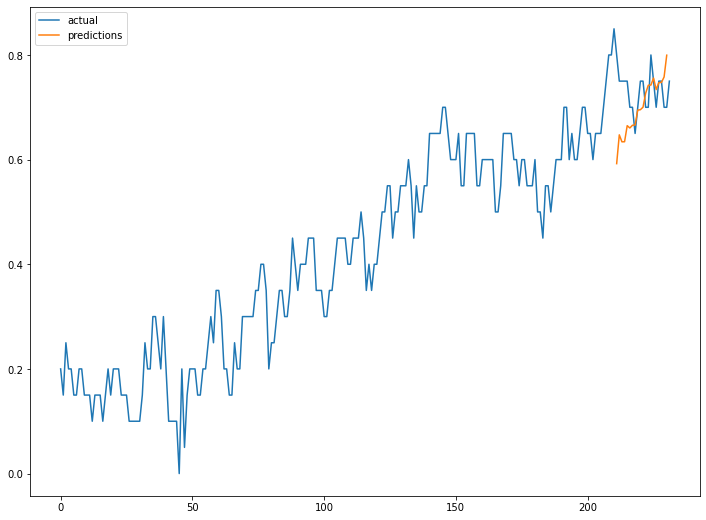

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 15.897748991846944 actual 0.8421052631578938 prediction 0.7082295
num 1 14.397203561031438 actual 0.8684210526315788 prediction 0.7433927
num 2 8.585152029991049 actual 0.8421052631578938 prediction 0.76980925
num 3 11.819564212452264 actual 0.8684210526315788 prediction 0.76577747
num 4 9.692730686881305 actual 0.8684210526315788 prediction 0.78424734
num 5 5.398188531398668 actual 0.8421052631578938 prediction 0.79664683
num 6 2.039415605606476 actual 0.8157894736842097 prediction 0.79915214
num 7 5.680504152851628 actual 0.8157894736842097 prediction 0.7694485
num 8 4.664732515811814 actual 0.8421052631578938 prediction 0.8028233
num 9 7.14360065758218 actual 0.8421052631578938 prediction 0.7819486
num 10 7.086703632817104 actual 0.8684210526315788 prediction 0.8068786
num 11 0.795069709420094 actual 0.8421052631578938 prediction 0.83540994
num 12 4.493408693986745 actual 0.8947368421052628 prediction 0.85453266
num 13 0.8068091941602089 actual 0.8684210526315788 prediction 0.

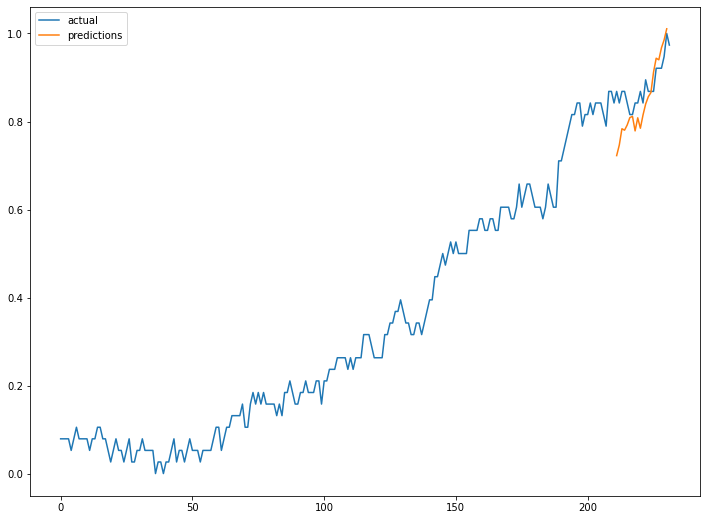

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.997490763664338 actual 0.76923076923077 prediction 0.6692501
num 1 5.394188353889991 actual 0.7307692307692317 prediction 0.69135016
num 2 2.466309070587286 actual 0.7307692307692317 prediction 0.7127462
num 3 2.285415875284423 actual 0.7307692307692317 prediction 0.7140681
num 4 5.06247546937741 actual 0.6923076923076916 prediction 0.7273556
num 5 3.991621732711894 actual 0.76923076923077 prediction 0.738526
num 6 8.341853959219874 actual 0.8076923076923084 prediction 0.7403158
num 7 10.405868008023292 actual 0.8076923076923084 prediction 0.7236449
num 8 11.727398092096559 actual 0.8461538461538467 prediction 0.746922
num 9 9.223497481573272 actual 0.8076923076923084 prediction 0.7331948
num 10 1.8688452243805977 actual 0.76923076923077 prediction 0.75485504
num 11 0.6451505422591091 actual 0.76923076923077 prediction 0.77419347
num 12 2.4886053800581793 actual 0.76923076923077 prediction 0.7883739
num 13 1.1624404362270646 actual 0.8076923076923084 prediction 0.79830337
num 

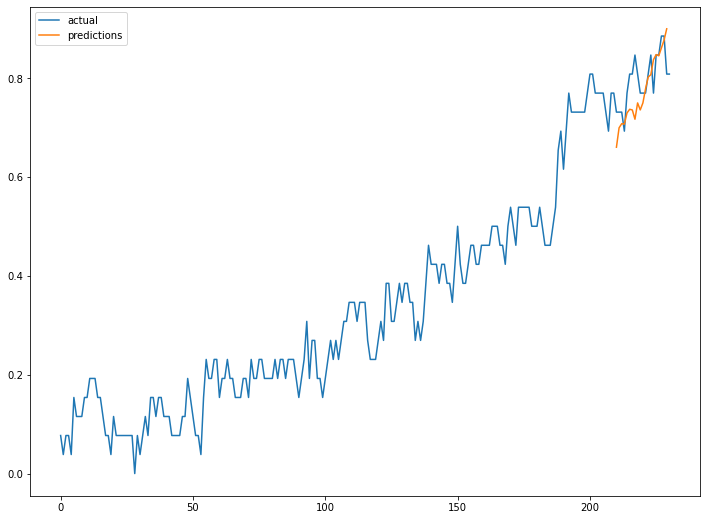

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()